<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Kaggle_tpu_petal_classifier_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!pip install timm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  57483      0 --:--:-- --:--:-- --:--:-- 58136
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
Done updating TPU runtime
  Successfully uninstalled torch-1.7.0
Found existing installation: torchvision 0.8.1
Uninstalling torchvision-0.8.1:
  Successfully uninstalled torchvision-0.8.1
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp37-cp37m-linux_x86_64.whl...
- [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp37-cp37m-linux_x86_64.whl...
| [1 files][119.5 MiB/119.5 MiB]                                            

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import glob
import tensorflow as tf
import timm
import random
import time
import copy
from operator import itemgetter

from collections import OrderedDict, namedtuple
import joblib

import logging
import sys

from PIL import Image
import cv2
import albumentations
import io
import IPython.display as display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection

import warnings
warnings.filterwarnings('ignore')

[('__call__', <function LevelMapper.__call__ at 0x7fa628b70440>), ('__init__', <function LevelMapper.__init__ at 0x7fa628b703b0>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7fa628a33d40>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7fa628a33cb0>)]
[('__init__', <function BoxCoder.__init__ at 0x7fa628a40560>), ('decode', <function BoxCoder.decode at 0x7fa628a40710>), ('decode_single', <function BoxCoder.decode_single at 0x7fa628a407a0>), ('encode', <function BoxCoder.encode at 0x7fa628a405f0>), ('encode_single', <function BoxCoder.encode_single at 0x7fa628a40680>)]
[('__call__', <function Matcher.__call__ at 0x7fa628a40320>), ('__init__', <function Matcher.__init__ at 0x7fa628a408c0>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7fa628a404d0>)]
[('__init__', <function ImageList.__init__ at 0x7fa628a403b0>), ('to', <function ImageList.to at 0x7fa628a409e0>)]
[('__init__', <function Timebase.__init__ at

In [ ]:
train_files = glob.glob('../input/tpu-getting-started/*/train/*.tfrec')
val_files = glob.glob('../input/tpu-getting-started/*/val/*.tfrec')
test_files = glob.glob('../input/tpu-getting-started/*/test/*.tfrec')

# 데이터 불러오기

In [ ]:
train_feature_description = {
    'class':tf.io.FixedLenFeature([], tf.int64),
    'id':tf.io.FixedLenFeature([], tf.string),
    'image':tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, train_feature_description)

train_ids = []
train_class = []
train_images = []

for i in train_files:
    train_image_dataset = tf.data.TFRecordDataset(i)
    
    train_image_dataset = train_image_dataset.map(_parse_image_function)
    
    ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset]
    
    train_ids = train_ids + ids
    
    classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
    train_class = train_class + classes
    
    images = [image_features['image'].numpy() for image_features in train_image_dataset]
    train_images = train_images + images

In [ ]:
val_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, val_feature_description)

val_ids = []
val_class = []
val_images = []

for i in val_files:
    val_image_dataset = tf.data.TFRecordDataset(i)

    val_image_dataset = val_image_dataset.map(_parse_image_function)

    ids = [str(image_features['id'].numpy())[2:-1] for image_features in val_image_dataset]
    val_ids += ids

    classes = [int(image_features['class'].numpy()) for image_features in val_image_dataset]
    val_class += classes 

    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images += images

In [ ]:
test_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

test_ids = []
test_images = []
for i in test_files:
    test_image_dataset = tf.data.TFRecordDataset(i)
    
    test_image_dataset = test_image_dataset.map(_parse_image_function_test)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in test_image_dataset]
    test_ids = test_ids + ids

    images = [image_features['image'].numpy() for image_features in test_image_dataset]
    test_images = test_images + images

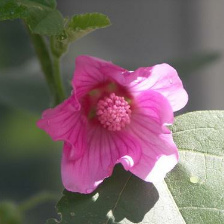

In [ ]:
display.display(display.Image(data=train_images[3]))

# Dataset 준비

In [ ]:
class MyDataset():
    def __init__(self, ids, cls, imgs, transforms, is_test=False):
        self.ids = ids
        if not is_test:
            self.cls = cls
        self.imgs = imgs
        self.transforms = transforms
        self.is_test = is_test
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = Image.open(io.BytesIO(img))
        img = self.transforms(img)
        if self.is_test:
            return img, -1, self.ids[idx]
        return img, int(self.cls[idx]), self.ids[idx]

# compose

In [ ]:
train_trans = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing()
])

test_trans = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_ds = MyDataset(train_ids, train_class, train_images, train_trans)
valid_ds = MyDataset(val_ids, val_class, val_images, test_trans)

In [ ]:
for x,y,d in train_ds:
    print(x)
    print(y)
    print(d)
    break

tensor([[[-2.0152, -1.0733,  0.3481,  ..., -0.7137, -0.7479, -0.7993],
         [-1.9295, -0.7479,  0.4679,  ..., -0.8507, -0.7822, -0.9363],
         [-1.9295, -0.6109,  0.5364,  ..., -1.2788, -1.2274, -1.2103],
         ...,
         [-1.8782, -1.7240, -1.5870,  ..., -1.3987, -1.4500, -1.5014],
         [-1.8782, -1.7754, -1.6555,  ..., -1.4843, -1.5014, -1.5699],
         [-1.9980, -1.8953, -1.8782,  ..., -1.4672, -1.5357, -1.5699]],

        [[-1.9132, -0.9328,  0.5203,  ..., -0.5126, -0.6001, -0.6001],
         [-1.8256, -0.5826,  0.6429,  ..., -0.6527, -0.6352, -0.7402],
         [-1.8256, -0.4426,  0.7129,  ..., -1.0903, -1.0903, -1.0203],
         ...,
         [-1.7206, -1.6506, -1.5630,  ..., -1.0378, -1.0553, -1.0903],
         [-1.7556, -1.7556, -1.6856,  ..., -0.8978, -0.9153, -0.9853],
         [-1.9132, -1.8957, -1.8782,  ..., -0.8803, -0.8978, -0.9153]],

        [[-1.5953, -0.5495,  0.9494,  ..., -0.3927, -0.4624, -0.4450],
         [-1.5081, -0.2010,  1.0714,  ..., -0

# TPU 모델

In [ ]:
device = xm.xla_device()

In [ ]:
train_sampler = torch.utils.data.distributed.DistributedSampler(
train_ds,
num_replicas=xm.xrt_world_size(),
rank=xm.get_ordinal(),
shuffle=True)

valid_sampler = torch.utils.data.distributed.DistributedSampler(
valid_ds,
num_replicas=xm.xrt_world_size(),
rank=xm.get_ordinal(),
shuffle=True)

train_loader = DataLoader(train_ds, batch_size=128, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_ds, 128, sampler=valid_sampler, num_workers=4, pin_memory=True)

dataset_size={
    'train':len(train_ds),
    'val':len(valid_ds)
}

In [ ]:
dataset_size

{'train': 51012, 'val': 14848}

이미 데이터를 정규화했지만, 이 단계에서는 매우 중요하기 때문에 좀 더 자세히 설명하겠습니다.

데이터셋에는 3채널 이미지가 있습니다. 즉, 각 채널에 대해 별도로 표준화해야 합니다(!!!). 데이터가 표준화되지 않았기 때문에 training 중에 정규화하는 등의 문제가 발생할 수 있지만, 이를 전혀 원하지 않습니다. 정규화의 과제는 평균이 가능한 0에 가깝게 하고 표준 편차는 1에 가깝게 하는 것이다.

In [ ]:
transforms_example = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

example = MyDataset(train_ids, train_class, train_images, transforms_example)

x, y, _= next(iter(DataLoader(example)))

loaders = {
    'train':train_loader,
    'val':val_loader,
}

[]

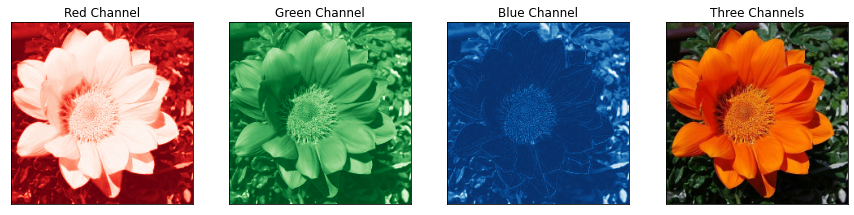

In [ ]:
channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15,10))
for i , axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([])

이제 test, train 및 valid 데이터셋에 대해 각 채널의 데이터를 얼마나 잘 정규화했는지 확인해 보겠습니다.

In [ ]:
#@title

channels = 3


for channel in range(channels):
    for x in ['train', 'val']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        num_pxl = dataset_size[x]*224*224
    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        sum_sqrt = 0
        for batch in loaders[x]: 
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)
        
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

Training for one epoch

In [ ]:
def train(loader, epoch, model, optimizer, criterion):
    model.train()
    running_loss = 0.
    running_corrects = 0.
    tot = 0
    
    for i,(ip, tgt, _) in enumerate(loader):
        ip, tgt = ip.to(device), tgt.to(device)
        output = model(ip)
        loss = criterion(output, tgt)
        tot+=ip.shape[0]
        
        _, pred = output.max(dim=1)
        running_corrects += torch.sum(pred == tgt.data)
        
        optimizer.zero_grad()
        loss.backward()
        xm.optimizer_step(optimizer)
        
        running_loss += loss.item() * ip.size(0)
    return running_corrects, running_loss

In [ ]:
def test(loader, model, criterion):
    with torch.no_grad():
        model.eval()
        running_loss = 0.
        running_corrects = 0.
        tot = 0
        for i, (ip, tgt, _) in enumerate(loader):
            ip, tgt = ip.to(device), tgt.to(device)
            output = model(ip)
            loss = criterion(output, tgt)
            tot += ip.shape[0]
            
            _, pred = output.max(dim=1)
            running_corrects += torch.sum(pred == tgt.data)
            running_loss += loss.item() * ip.size(0)
        return running_corrects, running_loss

In [ ]:
def predict(model, loader, device):
    with torch.no_grad():
        torch.cuda.empty_cache()
        model.eval()
        preds = dict()
        for i, (ip, _, ids) in enumerate(loader):
            ip = ip.to(device)
            output = model(ip)
            _, pred = output.max(dim=1)
            for i, j in zip(ids, pred.cpu().detach()):
                preds[i] = j
                
        return preds

In [ ]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Fit function structure:

1. Classifier Training
2. Network-wide Training
3. Predictions

In [ ]:
def fit(seed, epochs, model):
    xm.master_print('Creating a model {}...'.format(seed))
    device = xm.xla_device()
    WRAPPED_MODEL = xmp.MpModelWrapper(model)
    model = WRAPPED_MODEL.to(device)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    if seed==1:
        optimizer = torch.optim.Adam(model.head.parameters(), lr=0.001*xm.xrt_world_size(),
                                    betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    if seed==2 or seed==3:
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001*xm.xrt_world_size(),
                                    betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    if seed==4 or seed==0:
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001*xm.xrt_world_size(),
                                    betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
        
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
    since=time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        
        # train
        xm.master_print(f'Epoch:{epoch+1}/{epochs}')
        para_loader = pl.ParallelLoader(train_loader, [device])
        running_corrects, running_loss = train(para_loader.per_device_loader(device), epoch, model, optimizer, criterion)
        epoch_loss = running_loss / dataset_size['train']
        epoch_acc = running_corrects / dataset_size['train']
        losses['train'].append(epoch_loss)
        accuracies['train'].append(epoch_acc)
        xm.master_print(f"{'train'} - loss:{epoch_loss}, accuracy:{epoch_acc}")
        
        # val
        para_loader = pl.ParallelLoader(val_loader, [device])
        running_corrects, running_loss = test(para_loader.per_device_loader(device), model, criterion)
        epoch_loss = running_loss / dataset_size['val']
        epoch_acc = running_loss / dataset_size['val']
        losses['val'].append(epoch_loss)
        losses['val'].append(epoch_acc)
        xm.master_print(f"{'val'} - loss:{epoch_loss}, accuracy:{epoch_acc}")
        
        # epoch end
        xm.master_print('Time : {}m {}s'.format((time.time()-since)//60, (time.time()-since)%60))
        xm.master_print('=='*31)
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
        scheduler.step()
    
    time_elapsed = time.time() - since
    xm.master_print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
    xm.master_print('=='*31)
    
    model.load_state_dict(best_model)
    
    for param in model.parameters():
        param.requires_grad = True
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001*xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
    
    for epoch in range(epochs):
        #train
        xm.master_print('Epoch: {}/{}'.format(epoch+1, epochs))
        para_loader = pl.ParallelLoader(train_loader, [device])
        running_corrects, running_loss = train(para_loader.per_device_loader(device), epoch, model, optimizer, criterion)
        epoch_loss = running_loss / dataset_size['train']
        epoch_acc = running_corrects/dataset_size['train']
        losses['train'].append(epoch_loss)
        accuracies['train'].append(epoch_acc)
        xm.master_print('{} - loss:{}, accuracy{}'.format('train', epoch_loss, epoch_acc))

        #val
        para_loader = pl.ParallelLoader(val_loader, [device])
        running_corrects, running_loss = test(para_loader.per_device_loader(device), model, criterion)
        epoch_loss = running_loss / dataset_size['val']
        epoch_acc = running_corrects/dataset_size['val']
        losses['val'].append(epoch_loss)
        accuracies['val'].append(epoch_acc)
        xm.master_print('{} - loss:{}, accuracy{}'.format('val', epoch_loss, epoch_acc))
    
        #epoch end
        xm.master_print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        xm.master_print('=='*31)
        
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model = copy.deepcopy(model.state_dict())
        scheduler.step()

    time_elapsed = time.time() - since
    xm.master_print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
    xm.master_print('=='*31)
    
    model.load_state_dict(best_model)
    
    predictions = predict(model, testloader, device)
    for key in predictions.keys():
        ensemble_df.loc[ensemble_df['id'] == key, 'model_' + str(seed+1)] = int((predictions[key]).item())
        
    xm.master_print('Prediction Saved! \n')
        

# Densenet

In [ ]:
densenet121 = torchvision.models.densenet121(pretrained=True)

for param in densenet121.parameters():
    param.requires_grad=False
    
densenet121.classifier = nn.Linear(in_features = densenet121.classifier.in_features, out_features=104, bias=True)

# ViT

In [ ]:
ViT = timm.create_model('vit_base_patch16_224', pretrained=True)

for param in ViT.parameters():
    param.requires_grad=False
    
ViT.head = nn.Linear(in_features=ViT.head.in_features, out_features=104)

# GoogleNet

In [ ]:
googlenet = torchvision.models.googlenet(pretrained=True)

for param in googlenet.parameters():
    param.grad_requires=False
    
googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=104, bias=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

# Resnet

In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)

for param in resnet101.parameters():
    param.grad_requires = False
    
resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=104, bias=True)

# VGG19

In [ ]:
vgg19_bn  = torchvision.models.vgg19_bn(pretrained=True)

for param in vgg19_bn.parameters():
    param.grad_requires=False
    
vgg19_bn.classifier[6] = nn.Linear(4096, 104, bias=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# Launch

In [ ]:
test_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_ds = MyDataset(test_ids, [], test_images, test_transforms, True)

testloader=DataLoader(test_ds, 128, num_workers=4, pin_memory=True, shuffle=False)

submit_df=pd.read_csv('../input/tpu-getting-started/sample_submission.csv')

ensemble_df = submit_df.copy()

num_models=5
num_epochs=10

models = [densenet121, ViT, googlenet, resnet101, vgg19_bn]

for seed in range(num_models):
    preds = fit(seed=seed, epochs=num_epochs, model=models[seed])

Creating a model 0...
Epoch:1/10
train - loss:1.1133275130847047, accuracy:0.7249274849891663


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 763, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/opt/conda/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 492, in Client
    c = SocketClient(address)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 620, in SocketClient
    s

KeyboardInterrupt: 